In [75]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, RocCurveDisplay, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from joblib import dump, load
from imblearn.over_sampling import SMOTENC

In [10]:
data = pd.read_csv('./data/insurance/train.csv')

In [11]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [58]:
## The classes are highly unbalanced towards the 0-class, i.e. most customers are not interested in vehicle insurance
print('#class1/#allsamples: ', data[data['Response']==1].shape[0]/data.shape[0])
print('#class1/#class0: ', data[data['Response']==1].shape[0]/data[data['Response']==0].shape[0])

#class1/#allsamples:  0.12256336113815208
#class1/#class0:  0.13968343206767964


<h2>Define helper functions for later use</h2>

In [104]:
## Preprocessing pipeline which performs a one-hot-encoding for all categorical features and returns a train-test-split
def preprocessing(df, class_ratio=None):
    processed = df.copy()

    #Drop and transform certain columns
    processed.drop('id', axis=1, inplace=True)
    processed['Policy_Sales_Channel'] = processed['Policy_Sales_Channel'].astype('int32').astype('category')
    processed['Region_Code'] = processed['Region_Code'].astype('int32').astype('category')

    #upsampling with smote
    if class_ratio:
        smote = SMOTENC(categorical_features=[0,2,3,4,5,6,8], sampling_strategy=class_ratio, n_jobs=-1)
        X_res, y_res = smote.fit_resample(processed.iloc[:,:-1],processed.iloc[:,-1])
    else:
        X_res = processed.iloc[:,:-1]
        y_res = processed.iloc[:,-1]

    #OneHotEncoding    
    X_res = pd.get_dummies(X_res,drop_first=True)  

    #Train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test    

In [101]:
## Calculates important metrics to evaluate the performance of a classifier
def eval_clf_perf(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    metrics = {}
    metrics['accuracy'] = (tn + tp)/(tn+tp+fn+fp)
    metrics['sensitivity'] = (tp)/(tp+fn)
    metrics['precision'] = tp/(tp+fp)
    metrics['fscore'] = 2*metrics['precision']*metrics['sensitivity']/(metrics['precision']+metrics['sensitivity'])
    metrics['specificity'] = tn/(tn+fp)
    metrics['negative_precision'] = tn/(tn+fn)
    for key in metrics:
        print(key + ': ' + str(metrics[key]))
    return metrics

In [93]:
## Displays the calibration curve which helps to evaluate how close the predicted class probabilities correspond to actual probabilites
def eval_clf_calib(clf, X_test, y_test, clf_name=''):
    probs = clf.predict_proba(X_test)[:,1] #probabilities of class 1
    prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10, strategy='quantile')
    disp = CalibrationDisplay(prob_true, prob_pred, probs, estimator_name=clf_name)
    disp.plot()
    plt.show()

In [62]:
## Calculates the ROC curve and AUC score
def eval_clf_roc(clf, X_test, y_test, clf_name=''):
    fpr, tpr, _ = roc_curve(y_test.values, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=clf_name)
    display.plot()
    plt.show()

In [63]:
## Plot histogram of the predicted class probabilites
def class_probs_hist(clf, X_test, clf_name=''):
    probs = clf.predict_proba(X_test)[:,1]
    sns.histplot(probs, stat='probability')
    plt.title(clf_name)
    plt.show()

In [102]:
## Bundle evaluation functions
def eval_clf(clf, X_test, y_test, clf_name=''):
    metrics = eval_clf_perf(clf, X_test, y_test)
    eval_clf_calib(clf, X_test, y_test)
    eval_clf_roc(clf, X_test, y_test)
    class_probs_hist(clf, X_test, clf_name)
    return metrics

<h2>Test different models</h2>

In [65]:
X_train, X_test, y_train, y_test = preprocessing(data)

accuracy:  0.6328835574907037
sensitivity:  0.9105209742895806
precision:  0.8327054669869695
F-score: 0.8698764258555134


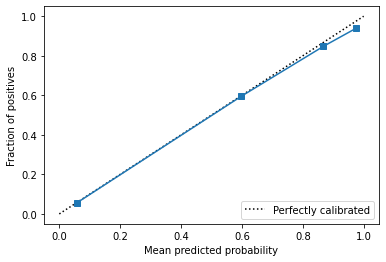

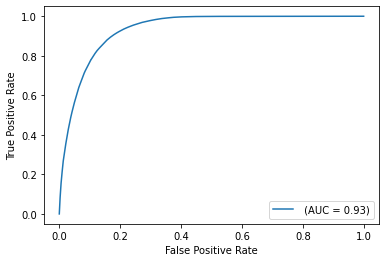

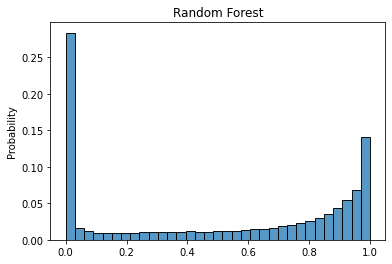

In [66]:
rf = RandomForestClassifier().fit(X_train, y_train)
eval_clf(rf, X_test, y_test, clf_name='Random Forest')

accuracy:  0.6156811159717336
sensitivity:  0.8710996577250657
precision:  0.766454222331168
F-score: 0.8154333348856704


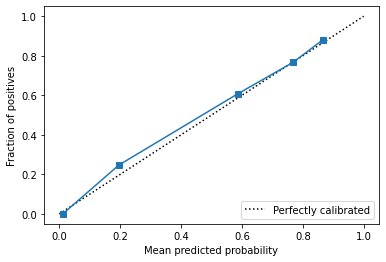

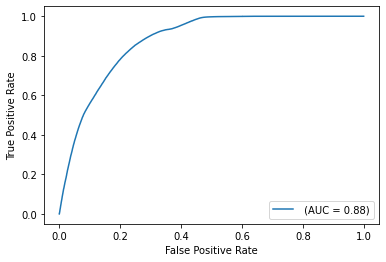

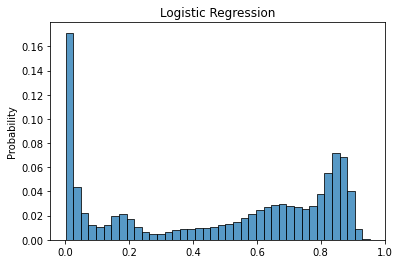

In [67]:
lr = LogisticRegression().fit(X_train, y_train)
eval_clf(lr, X_test, y_test, clf_name='Logistic Regression')

accuracy:  0.8760042097877565
sensitivity:  0.056868015277974256
precision:  0.4185320145757418
F-score: 0.10013076779376051


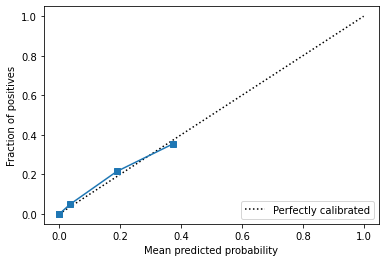

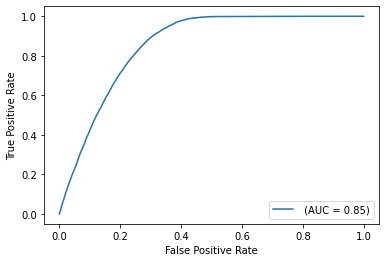

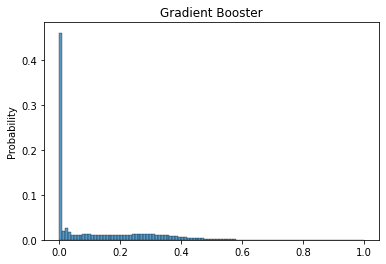

In [25]:
#gb = GradientBoostingClassifier(n_estimators=700,learning_rate=0.1, max_depth=8).fit(X_train, y_train)
gb = load('gb_est700_rate0.1_maxdepth8.joblib')
eval_clf(gb, X_test, y_test, clf_name='Gradient Booster')

In [92]:
dump(gb, 'gb_est700_rate0.1_maxdepth8.joblib')

['gb_est700_rate0.1_maxdepth8.joblib']

<h2>Find best upsampling ratio</h2>

- Looking at the results below, it seems quite clear that the best class balance seems to be 50-50

In [ ]:
ratios = [0.2,0.4,0.6,0.8,1.0]
for ratio in ratios:
    print('Current Ratio: ', ratio)
    X_train, X_test, y_train, y_test = preprocessing(data, class_ratio=ratio)
    lr = LogisticRegression().fit(X_train, y_train)
    eval_clf(lr, X_test, y_test, clf_name='Logistic Regression')

Current Ratio:  0.2
accuracy: 0.8404023790536949
sensitivity: 0.35895004740755526
precision: 0.5304572271386431
fscore: 0.42816750498526746
specificity: 0.936548906273357
negative_precision: 0.8797461244664121


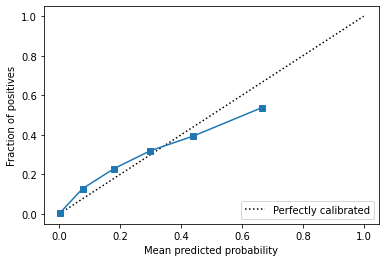

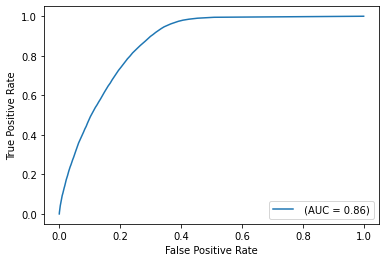

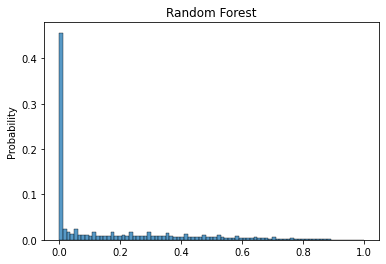

Current Ratio:  0.4
accuracy: 0.8279291979949874
sensitivity: 0.7058138382236321
precision: 0.6984574637663389
fscore: 0.7021163825512456
specificity: 0.8771579283887468
negative_precision: 0.8808981549297188


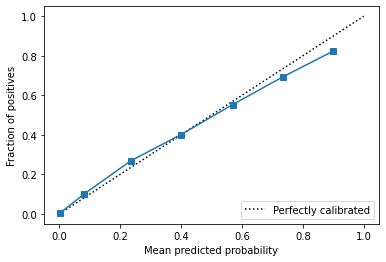

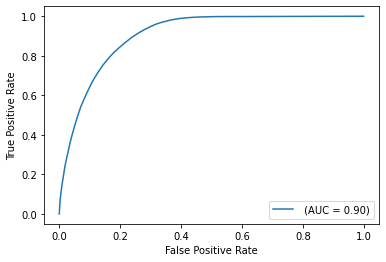

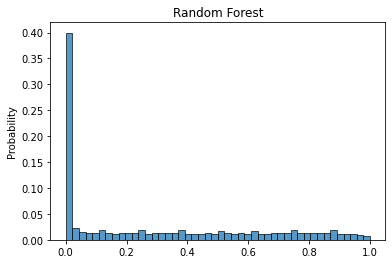

Current Ratio:  0.6
accuracy: 0.837850129585327
sensitivity: 0.8217520650168691
precision: 0.763661075587681
fscore: 0.7916423167754072
specificity: 0.8475030644888034
negative_precision: 0.8880082701585114


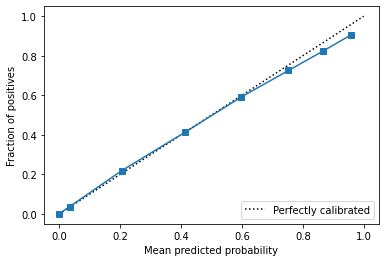

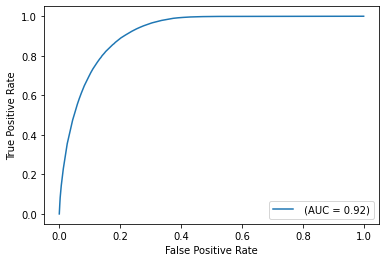

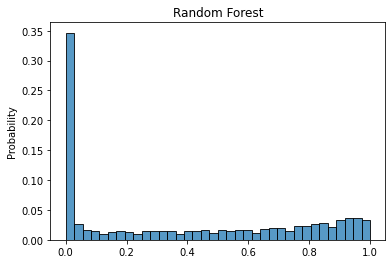

Current Ratio:  0.8
accuracy: 0.8504120148856991
sensitivity: 0.878533640380905
precision: 0.8035545536314058
fscore: 0.8393730004876134
specificity: 0.8278748216797518
negative_precision: 0.8947867809585422


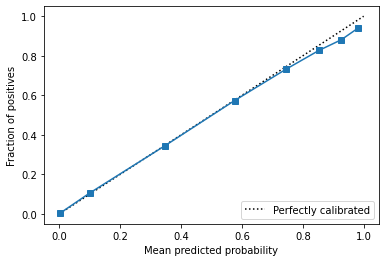

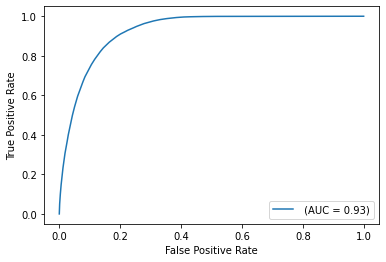

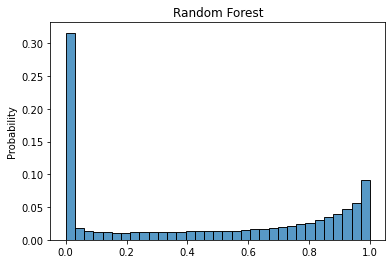

Current Ratio:  1.0
accuracy: 0.8629435805422647
sensitivity: 0.9091578444639019
precision: 0.8326180257510729
fscore: 0.8692062193515246
specificity: 0.8165594791084125
negative_precision: 0.8995566410332574


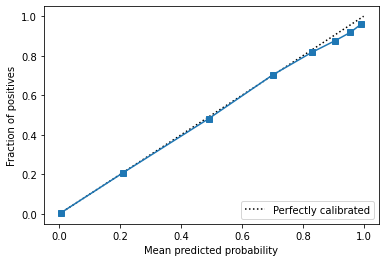

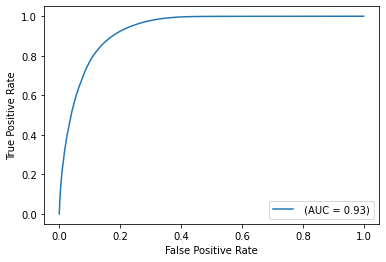

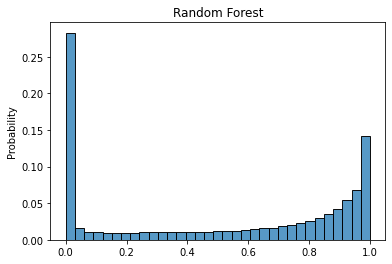

In [105]:
ratios = [0.2,0.4,0.6,0.8,1.0]
metrics = []
for ratio in ratios:
    print('Current Ratio: ', ratio)
    X_train, X_test, y_train, y_test = preprocessing(data, class_ratio=ratio)
    rf = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)
    metrics.append(eval_clf(rf, X_test, y_test, clf_name='Random Forest'))

In [106]:
for metric in metrics:
    print(metric)

{'accuracy': 0.8404023790536949, 'sensitivity': 0.35895004740755526, 'precision': 0.5304572271386431, 'fscore': 0.42816750498526746, 'specificity': 0.936548906273357, 'negative_precision': 0.8797461244664121}
{'accuracy': 0.8279291979949874, 'sensitivity': 0.7058138382236321, 'precision': 0.6984574637663389, 'fscore': 0.7021163825512456, 'specificity': 0.8771579283887468, 'negative_precision': 0.8808981549297188}
{'accuracy': 0.837850129585327, 'sensitivity': 0.8217520650168691, 'precision': 0.763661075587681, 'fscore': 0.7916423167754072, 'specificity': 0.8475030644888034, 'negative_precision': 0.8880082701585114}
{'accuracy': 0.8504120148856991, 'sensitivity': 0.878533640380905, 'precision': 0.8035545536314058, 'fscore': 0.8393730004876134, 'specificity': 0.8278748216797518, 'negative_precision': 0.8947867809585422}
{'accuracy': 0.8629435805422647, 'sensitivity': 0.9091578444639019, 'precision': 0.8326180257510729, 'fscore': 0.8692062193515246, 'specificity': 0.8165594791084125, 'neg

<h2>Calibration of the Models</h2>

- It turns out that our models are already quite well calibrated and further calibration is not needed

In [26]:
X_calib, X_val, y_calib, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=45)

accuracy:  0.8770549265659504
sensitivity:  0.02879543834640057
precision:  0.3937621832358674
F-score: 0.0536663124335813


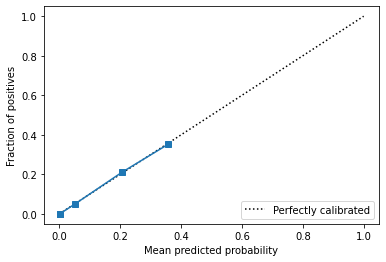

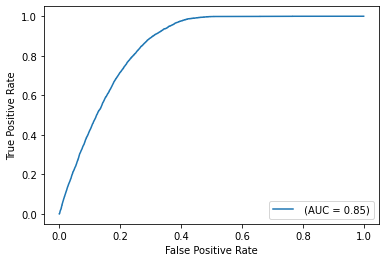

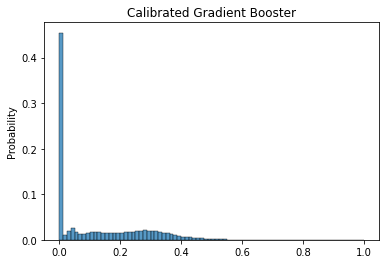

In [27]:
gb_calib = CalibratedClassifierCV(base_estimator=gb, method='sigmoid', cv='prefit').fit(X_calib,y_calib)
eval_clf(gb_calib, X_val, y_val, clf_name='Calibrated Gradient Booster')

accuracy:  0.8762153482380759
sensitivity:  0.0888096935138988
precision:  0.3576349024110218


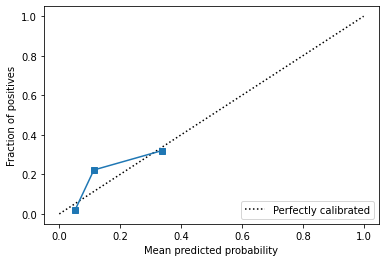

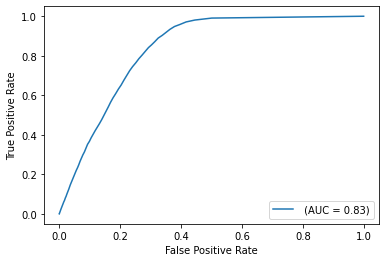

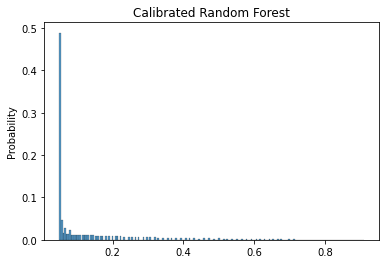

In [86]:
rf_calib = CalibratedClassifierCV(base_estimator=rf, method='sigmoid', cv='prefit').fit(X_calib,y_calib)
eval_clf(rf_calib, X_val, y_val, clf_name='Calibrated Random Forest')

accuracy:  0.8762061537922701
sensitivity:  0.0038194935634460318
precision:  0.2297872340425532


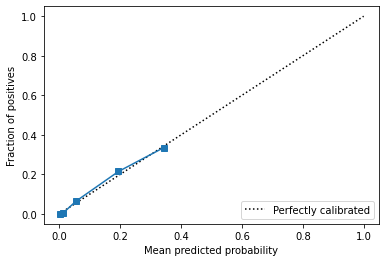

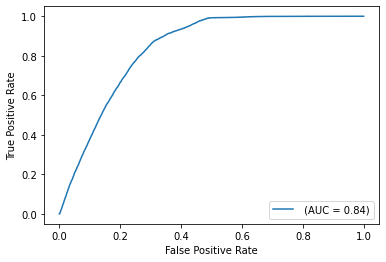

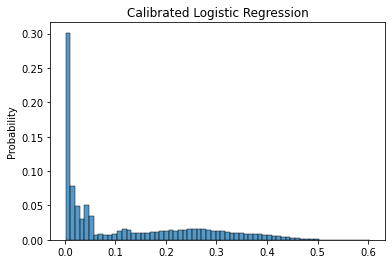

In [90]:
lrc = LogisticRegression()
lr_calib = CalibratedClassifierCV(base_estimator=lrc, method='sigmoid').fit(X_train,y_train)
eval_clf(lr_calib, X_test, y_test, clf_name='Calibrated Logistic Regression')